**ЛИНЕЙНЫЕ КЛАССИФИКАТОРЫ**

Построить линейный классификатор, максимизирующий кри-
терий Фишера, для классов 0  и 1  двумерных нормально рас-
пределенных векторов признаков для случаев равных и неравных
корреляционных матриц. Сравнить качество полученного класси-
фикатора с байесовским классификатором

Построить линейный классификатор, минимизирующий сред-
неквадратичную ошибку, для классов 0 и 1 двумерных
нормально распределенных векторов признаков для случаев
равных и неравных корреляционных матриц. Сравнить каче-
ство полученного классификатора с классификатором Байеса
и классификатором Фишера.

Построить линейный классификатор, основанный на процеду-
ре Роббинса-Монро, для классов 0  и 1  двумерных нор-
мально распределенных векторов признаков для случаев рав-
ных и неравных корреляционных матриц. Исследовать зави-
симость скорости сходимости итерационного процесса и ка-
чества классификации от выбора начальных условий и выбора
последовательности корректирующих коэффициентов. Срав-
нить качество полученного классификатора с байесовским
классификатором

In [36]:
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from numpy import sign as sgn
from random import randint

M0 = np.array([1.0, 0.0])
M1 = np.array([-1.0, 1.0])

# Одинаковая для обоих распределений
B = np.array([[0.7, 0.4],
              [0.4, 0.7]])
 
# Разные корреляционные матрицы для каждого класса
B0 = np.array([[0.8, 0.7],   
               [0.7, 0.8]])

B1 = np.array([[0.7, -0.5], 
               [-0.5, 0.7]])

# наборы для равных корреляционных матриц
X0_equal = np.load("2d_class0_samples.npy", allow_pickle=True)
X1_equal = np.load("2d_class1_samples.npy", allow_pickle=True)

# наборы для НЕ равных корреляционных матриц
X0_diff = np.load("3d_class0_samples.npy", allow_pickle=True)
X1_diff = np.load("3d_class1_samples.npy", allow_pickle=True)

# параметры байесовского классификатора для ситуации равных корреляционных матриц
db_equal = np.load("bayes_2D_.npy", allow_pickle=True)
#  параметры байесовского классификатора для ситуации неравных корреляционных матриц
db_diff = np.load("bayes_3D_0_and_1.npy", allow_pickle=True)



In [ ]:
def shuffle(a: list):
    """Возвращает перемешанную копию списка"""
    # Создаем копию исходного списка, чтобы не изменять оригинал
    b = a.copy()
    n = len(a)
    # Алгоритм Фишера-Йейтса: проходим по всем элементам кроме последнего
    for i in range(n-1):
        # Выбираем случайный индекс из оставшейся части списка
        r = randint(i+1, n-1)
        # Меняем местами текущий элемент со случайно выбранным
        b[i], b[r] = b[r], b[i]
    return b


def fisher_classifier_equal_cov(B: np.ndarray, M0: np.ndarray, M1: np.ndarray):
    """Классификатор Фишера для равных ковариационных матриц"""
    # Вычисляем весовой вектор W
    W = inv(B) @ (M1 - M0)
    # Вычисляем пороговое значение wn
    wn = -0.5 * (M1 - M0).T @ inv(B) @ (M1 + M0)
    return W, wn


def fisher_classifier_diff_cov(B0: np.ndarray, B1: np.ndarray, M0: np.ndarray, M1: np.ndarray):
    """Классификатор Фишера для разных ковариационных матриц"""
    # Преобразование средних в вектор-столбцы (если они представлены как одномерные массивы)
    M0 = np.array([[M0[0]], [M0[1]]]) if M0.ndim == 1 else M0
    M1 = np.array([[M1[0]], [M1[1]]]) if M1.ndim == 1 else M1
    
    # Вычисляем весовой вектор W
    W = 0.5 * inv(B0 + B1) @ (M1 - M0)
    # Вычисляем дисперсии проекций для каждого класса
    sigma0_sq = W.T @ B0 @ W
    sigma1_sq = W.T @ B1 @ W
    # Вычисляем пороговое значение wn
    wn = - ((M1.T - M0.T) @ (0.5 * inv(B0 + B1)) @ (sigma1_sq * M0 + sigma0_sq * M1)) / (sigma0_sq + sigma1_sq)
    
    # Преобразуем результат к скалярным значениям и возвращаем
    return [float(W[0, 0]), float(W[1, 0])], float(wn[0, 0])


def minstd_classifier(X0: np.ndarray, X1: np.ndarray):
    """Классификатор, минимизирующий СКО"""
    # Подготовка данных класса 0: добавляем столбец единиц и умножаем на -1
    z0 = -1 * np.column_stack([X0, np.ones(len(X0))])  # Класс 0
    # Подготовка данных класса 1: добавляем столбец единиц
    z1 = np.column_stack([X1, np.ones(len(X1))])       # Класс 1
    
    # Объединяем данные обоих классов в одну матрицу
    U = np.vstack([z1, z0])  # Объединяем данные (просто по вертикали плюсуем)
    # Создаем вектор целевых значений (все единицы)
    Gamma = np.ones((len(U), 1))  # Вектор требуемых выходов
    
    # Решение методом наименьших квадратов: W = (UᵀU)⁻¹UᵀΓ
    W = inv(U.T @ U) @ U.T @ Gamma
    # Возвращаем веса и порог (последний элемент - смещение)
    return W[:-1].flatten(), W[-1, 0]


def ACP_classifier(X0: np.ndarray, X1: np.ndarray, W0 = np.array([[1.0, 1.0, 1.0]]).T, max_iterations=1000, beta=0.8):
    """Алгоритм Роббинса-Монро (стохастическая аппроксимация)"""
    # Подготавливаем данные с расширенным признаковым пространством
    z0 = np.column_stack([X0, np.ones(len(X0)), -1 * np.ones(len(X0))])  # [x, y, 1, -1]
    z1 = np.column_stack([X1, np.ones(len(X1)), np.ones(len(X1))])       # [x, y, 1, 1]
    
    # Объединяем все данные
    z = np.vstack([z0, z1])  # Объединяем все данные
    z_data = z[:, :3].T      # Признаки [x, y, 1] (транспонированы для удобства)
    z_labels = z[:, 3]       # Метки классов
    
    # Инициализация весов (начальное приближение)
    # W = np.array([[1.0, 1.0, 1.0]]).T
    W = W0
    # Сохраняем историю изменений весов для анализа сходимости
    Warr = [W.copy()]
    n_samples = len(z_labels)
    
    k = 0  # Счетчик обновлений для расчета шага обучения
    for iteration in range(max_iterations):
        # Перемешиваем данные на каждой итерации для улучшения сходимости
        indices = shuffle(list(range(n_samples)))
        
        # Проход по всем образцам в перемешанном порядке
        for i in range(n_samples):
            j = indices[i]
            # Вычисляем убывающий шаг обучения
            alpha = 1 / (k + 1) ** beta
            k += 1
            
            x = z_data[:, j:j+1]  # Вектор признаков текущего образца
            r = z_labels[j]       # Правильный класс текущего образца
            
            # Обновление весов по правилу Роббинса-Монро:
            # W(k+1) = W(k) + αₖ * X(k) * sgn(r(X(k)) - W(k)ᵀX(k))
            W = W + alpha * x * sgn(r - W.T @ x)
        
        # Сохраняем текущие веса в историю
        Warr.append(W.copy())
        
        # Проверка сходимости: если изменение весов мало, останавливаемся
        if norm(Warr[-1] - Warr[-2]) < 0.001:
            # когда веса почти перестают меняться, обучение завершается
            print(f"Сходимость достигнута за {iteration} итераций")
            break
    
    return Warr, iteration

def get_y(x: list, W: list, wn: float):
    """Построение линии классификатора: W[0]*x + W[1]*y + wn = 0"""
    # Преобразуем уравнение разделяющей линии к виду y = kx + b
    return [-W[0]/W[1] * i - wn/W[1] for i in x]

=== Случай равных ковариационных матриц ===
Сходимость достигнута за 55 итераций

АНАЛИТИЧЕСКИЕ ВЫРАЖЕНИЯ ДЛЯ КЛАССИФИКАТОРОВ

1. КЛАССИФИКАТОР ФИШЕРА:
Дискриминантная функция:
d(x) = -5.4545 *x₁ + 4.5455 *x₂ + -2.2727 = 0
Уравнение разделяющей прямой:
x₂ = 1.2000*x₁ + 0.5000

2. КЛАССИФИКАТОР МИНИМИЗИРУЮЩИЙ СКО:
Дискриминантная функция:
d(x) = -0.5854 *x₁ + 0.4905 *x₂ + -0.2631 = 0
Уравнение разделяющей прямой:
x₂ = 1.1936*x₁ + 0.5365

3. АЛГОРИТМ РОББИНСА-МОНРО (АКП):
Дискриминантная функция:
d(x) = -0.5939 *x₁ + 0.4765 *x₂ + -0.2646 = 0
Уравнение разделяющей прямой:
x₂ = 1.2463*x₁ + 0.5554


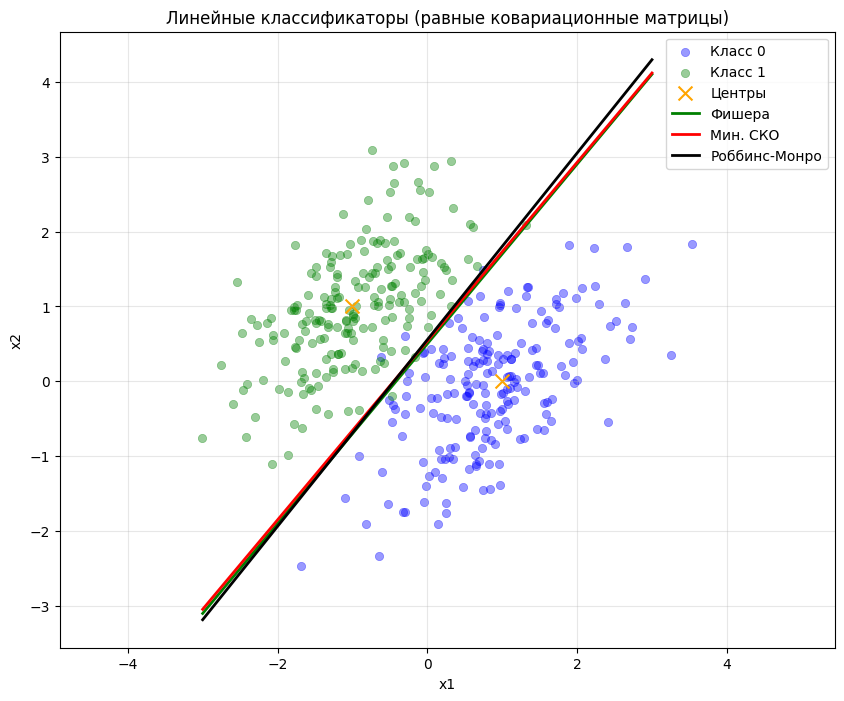

In [ ]:
print("=== Случай равных ковариационных матриц ===")

# Извлекаем данные для построения графиков
x0_eq, y0_eq = X0_equal[:, 0], X0_equal[:, 1]
x1_eq, y1_eq = X1_equal[:, 0], X1_equal[:, 1]

# Байесовский классификатор (уже построен)
bx_equal, by_equal = db_equal[0], db_equal[1]

# Классификатор Фишера
fisher_x_eq = [-3, 3]
W_fisher_eq, wn_fisher_eq = fisher_classifier_equal_cov(B, M0, M1)
fisher_y_eq = get_y(fisher_x_eq, W_fisher_eq, wn_fisher_eq)

# Классификатор, минимизирующий СКО
minstd_x_eq = [-3, 3]
W_minstd_eq, wn_minstd_eq = minstd_classifier(X0_equal, X1_equal)
minstd_y_eq = get_y(minstd_x_eq, W_minstd_eq, wn_minstd_eq)

# Алгоритм Роббинса-Монро
Warr_eq, iteration = ACP_classifier(X0_equal, X1_equal)
acp_x_eq = [-3, 3]
acp_y_eq_final = get_y(acp_x_eq, [Warr_eq[-1][0, 0], Warr_eq[-1][1, 0]], Warr_eq[-1][2, 0])


print("\nАНАЛИТИЧЕСКИЕ ВЫРАЖЕНИЯ ДЛЯ КЛАССИФИКАТОРОВ")
print("\n1. КЛАССИФИКАТОР ФИШЕРА:")
print(f"Дискриминантная функция:")
print(f"d(x) = {W_fisher_eq[0]:.4f} *x₁ + {W_fisher_eq[1]:.4f} *x₂ + {wn_fisher_eq:.4f} = 0")
print(f"Уравнение разделяющей прямой:")
print(f"x₂ = {(-W_fisher_eq[0]/W_fisher_eq[1]):.4f}*x₁ + {(-wn_fisher_eq/W_fisher_eq[1]):.4f}")
print("\n2. КЛАССИФИКАТОР МИНИМИЗИРУЮЩИЙ СКО:")
print(f"Дискриминантная функция:")
print(f"d(x) = {W_minstd_eq[0]:.4f} *x₁ + {W_minstd_eq[1]:.4f} *x₂ + {wn_minstd_eq:.4f} = 0")
print(f"Уравнение разделяющей прямой:")
print(f"x₂ = {(-W_minstd_eq[0]/W_minstd_eq[1]):.4f}*x₁ + {(-wn_minstd_eq/W_minstd_eq[1]):.4f}")
W_acp = [Warr_eq[-1][0, 0], Warr_eq[-1][1, 0]]
wn_acp = Warr_eq[-1][2, 0]
print("\n3. АЛГОРИТМ РОББИНСА-МОНРО (АКП):")
print(f"Дискриминантная функция:")
print(f"d(x) = {W_acp[0]:.4f} *x₁ + {W_acp[1]:.4f} *x₂ + {wn_acp:.4f} = 0")
print(f"Уравнение разделяющей прямой:")
print(f"x₂ = {(-W_acp[0]/W_acp[1]):.4f}*x₁ + {(-wn_acp/W_acp[1]):.4f}")

plt.figure(figsize=(10, 8))
plt.scatter(x0_eq, y0_eq, c='blue', linewidths=0.5, alpha=0.4, label='Класс 0')
plt.scatter(x1_eq, y1_eq, c='green', linewidths=0.5, alpha=0.4, label='Класс 1')
plt.scatter([M0[0], M1[0]], [M0[1], M1[1]], marker="x", color="orange", s=100, label='Центры')

# plt.plot(bx_equal, by_equal, 'b-', label='Байесовский', linewidth=2)
plt.plot(fisher_x_eq, fisher_y_eq, 'g-', label='Фишера', linewidth=2)
plt.plot(minstd_x_eq, minstd_y_eq, 'r-', label='Мин. СКО', linewidth=2)
plt.plot(acp_x_eq, acp_y_eq_final, 'k-', label='Роббинс-Монро', linewidth=2)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Линейные классификаторы (равные ковариационные матрицы)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.



=== Случай разных ковариационных матриц ===
Сходимость достигнута за 43 итераций

АНАЛИТИЧЕСКИЕ ВЫРАЖЕНИЯ ДЛЯ СЛУЧАЯ РАЗНЫХ КОВАРИАЦИОННЫХ МАТРИЦ

1. КЛАССИФИКАТОР ФИШЕРА (разные ковариации):
Дискриминантная функция:
d(x) = -0.7240*x₁ + 0.4299*x₂ + 0.4611 = 0
Уравнение разделяющей прямой:
x₂ = 1.6842*x₁ + -1.0726

2. КЛАССИФИКАТОР МИНИМИЗИРУЮЩИЙ СКО (разные ковариации):
Дискриминантная функция:
d(x) = -0.5087*x₁ + 0.2938*x₂ + -0.1387 = 0
Уравнение разделяющей прямой:
x₂ = 1.7311*x₁ + 0.4721

3. АЛГОРИТМ РОББИНСА-МОНРО (разные ковариации):
Дискриминантная функция:
d(x) = -0.5402*x₁ + 0.4124*x₂ + -0.3266 = 0
Уравнение разделяющей прямой:
x₂ = 1.3100*x₁ + 0.7920


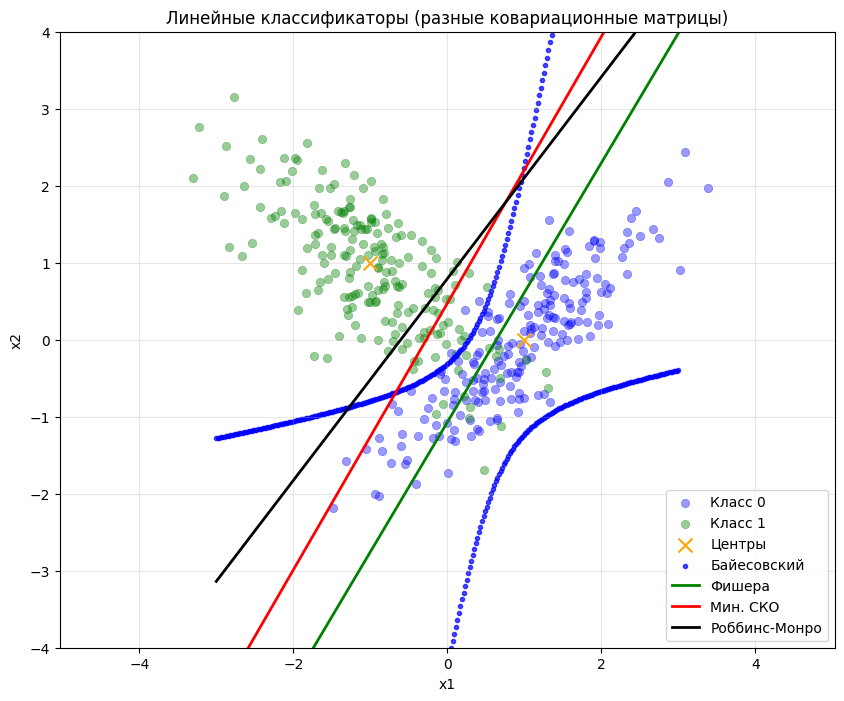

In [54]:
print("\n=== Случай разных ковариационных матриц ===")

# Извлекаем данные
x0_diff, y0_diff = X0_diff[:, 0], X0_diff[:, 1]
x1_diff, y1_diff = X1_diff[:, 0], X1_diff[:, 1]

# Байесовский классификатор
bx_diff, by_diff = db_diff[0], db_diff[1]
bayes_boundary_points = np.array(by_diff)

# Обработка байесовской границы (сортировка для гладкого отображения)
tx = [i[0] for i in by_diff]
ty = [i[1] for i in by_diff]
for i in range(len(tx)-1):
    for j in range(len(tx)-1-i):
        if ty[j] > ty[j+1]:
            ty[j], ty[j+1] = ty[j+1], ty[j]
            tx[j], tx[j+1] = tx[j+1], tx[j]

# Классификатор Фишера
fisher_x_diff = [-3, 3]
W_fisher_diff, wn_fisher_diff = fisher_classifier_diff_cov(B0, B1, M0, M1)
fisher_y_diff = get_y(fisher_x_diff, W_fisher_diff, wn_fisher_diff)

# Классификатор, минимизирующий СКО
minstd_x_diff = [-3, 3]
W_minstd_diff, wn_minstd_diff = minstd_classifier(X0_diff, X1_diff)
minstd_y_diff = get_y(minstd_x_diff, W_minstd_diff, wn_minstd_diff)

# Алгоритм Роббинса-Монро
Warr_diff, iteration = ACP_classifier(X0_diff, X1_diff)
acp_x_diff = [-3, 3]
acp_y_diff_final = get_y(acp_x_diff, [Warr_diff[-1][0, 0], Warr_diff[-1][1, 0]], Warr_diff[-1][2, 0])


print("\nАНАЛИТИЧЕСКИЕ ВЫРАЖЕНИЯ ДЛЯ СЛУЧАЯ РАЗНЫХ КОВАРИАЦИОННЫХ МАТРИЦ")
print("\n1. КЛАССИФИКАТОР ФИШЕРА (разные ковариации):")
print(f"Дискриминантная функция:")
print(f"d(x) = {W_fisher_diff[0]:.4f}*x₁ + {W_fisher_diff[1]:.4f}*x₂ + {wn_fisher_diff:.4f} = 0")
print(f"Уравнение разделяющей прямой:")
print(f"x₂ = {(-W_fisher_diff[0]/W_fisher_diff[1]):.4f}*x₁ + {(-wn_fisher_diff/W_fisher_diff[1]):.4f}")
print("\n2. КЛАССИФИКАТОР МИНИМИЗИРУЮЩИЙ СКО (разные ковариации):")
print(f"Дискриминантная функция:")
print(f"d(x) = {W_minstd_diff[0]:.4f}*x₁ + {W_minstd_diff[1]:.4f}*x₂ + {wn_minstd_diff:.4f} = 0")
print(f"Уравнение разделяющей прямой:")
print(f"x₂ = {(-W_minstd_diff[0]/W_minstd_diff[1]):.4f}*x₁ + {(-wn_minstd_diff/W_minstd_diff[1]):.4f}")
W_acp_diff = [Warr_diff[-1][0, 0], Warr_diff[-1][1, 0]]
wn_acp_diff = Warr_diff[-1][2, 0]
print("\n3. АЛГОРИТМ РОББИНСА-МОНРО (разные ковариации):")
print(f"Дискриминантная функция:")
print(f"d(x) = {W_acp_diff[0]:.4f}*x₁ + {W_acp_diff[1]:.4f}*x₂ + {wn_acp_diff:.4f} = 0")
print(f"Уравнение разделяющей прямой:")
print(f"x₂ = {(-W_acp_diff[0]/W_acp_diff[1]):.4f}*x₁ + {(-wn_acp_diff/W_acp_diff[1]):.4f}")


plt.figure(figsize=(10, 8))
plt.scatter(x0_diff, y0_diff, c='blue', linewidths=0.5, alpha=0.4, label='Класс 0')
plt.scatter(x1_diff, y1_diff, c='green', linewidths=0.5, alpha=0.4, label='Класс 1')
plt.scatter([M0[0], M1[0]], [M0[1], M1[1]], marker="x", color="orange", s=100, label='Центры')

plt.scatter(bayes_boundary_points[:, 0], bayes_boundary_points[:, 1], 
           c='blue', marker='.', alpha=0.7, label='Байесовский')
plt.plot(fisher_x_diff, fisher_y_diff, 'g-', label='Фишера', linewidth=2)
plt.plot(minstd_x_diff, minstd_y_diff, 'r-', label='Мин. СКО', linewidth=2)
plt.plot(acp_x_diff, acp_y_diff_final, 'k-', label='Роббинс-Монро', linewidth=2)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Линейные классификаторы (разные ковариационные матрицы)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.axis([-4, 4, -4, 4])  
plt.show()

In [40]:
# ========== СРАВНЕНИЕ КАЧЕСТВА КЛАССИФИКАТОРОВ ==========
def calculate_error_rate(X0, X1, W, wn):
    """Вычисление ошибки классификации"""
    errors = 0
    total = len(X0) + len(X1)
    
    # Класс 0 (должны быть < 0)
    for sample in X0:
        if W[0] * sample[0] + W[1] * sample[1] + wn >= 0:
            errors += 1
    
    # Класс 1 (должны быть > 0)
    for sample in X1:
        if W[0] * sample[0] + W[1] * sample[1] + wn < 0:
            errors += 1
    
    return errors / total

print("\n=== Сравнение ошибок классификации ===")
print("Равные ковариационные матрицы:")
print(f"Фишер: {calculate_error_rate(X0_equal, X1_equal, W_fisher_eq, wn_fisher_eq):.3f}")
print(f"Мин. СКО: {calculate_error_rate(X0_equal, X1_equal, W_minstd_eq, wn_minstd_eq):.3f}")
print(f"Роббинс-Монро: {calculate_error_rate(X0_equal, X1_equal, [Warr_eq[-1][0, 0], Warr_eq[-1][1, 0]], Warr_eq[-1][2, 0]):.3f}")

print("\nРазные ковариационные матрицы:")
print(f"Фишер: {calculate_error_rate(X0_diff, X1_diff, W_fisher_diff, wn_fisher_diff):.3f}")
print(f"Мин. СКО: {calculate_error_rate(X0_diff, X1_diff, W_minstd_diff, wn_minstd_diff):.3f}")
print(f"Роббинс-Монро: {calculate_error_rate(X0_diff, X1_diff, [Warr_diff[-1][0, 0], Warr_diff[-1][1, 0]], Warr_diff[-1][2, 0]):.3f}")


=== Сравнение ошибок классификации ===
Равные ковариационные матрицы:
Фишер: 0.010
Мин. СКО: 0.015
Роббинс-Монро: 0.015

Разные ковариационные матрицы:
Фишер: 0.158
Мин. СКО: 0.077
Роббинс-Монро: 0.107


=== ИССЛЕДОВАНИЕ НАЧАЛЬНЫХ УСЛОВИЙ ===
Тест 1: Единичные веса = [1. 1. 1.]
Сходимость достигнута за 48 итераций
  Итерации: 48, Точность: 0.892
  Конечные веса: [-0.53659974  0.4140207  -0.32237736]
Тест 2: Нулевые веса = [0. 0. 0.]
Сходимость достигнута за 43 итераций
  Итерации: 43, Точность: 0.892
  Конечные веса: [-0.54023521  0.41124413 -0.32177219]
Тест 3: Малые веса = [0.1 0.1 0.1]
Сходимость достигнута за 47 итераций
  Итерации: 47, Точность: 0.892
  Конечные веса: [-0.53540982  0.41458173 -0.32450063]
Тест 4: Большие веса = [10. 10. 10.]
Сходимость достигнута за 52 итераций
  Итерации: 52, Точность: 0.892
  Конечные веса: [-0.53537729  0.4141742  -0.32219241]
Тест 5: Случайные веса = [-0.06185264  2.43742752 -1.41112681]
Сходимость достигнута за 59 итераций
  Итерации: 59, Точность: 0.892
  Конечные веса: [-0.5378764   0.41325618 -0.32222872]


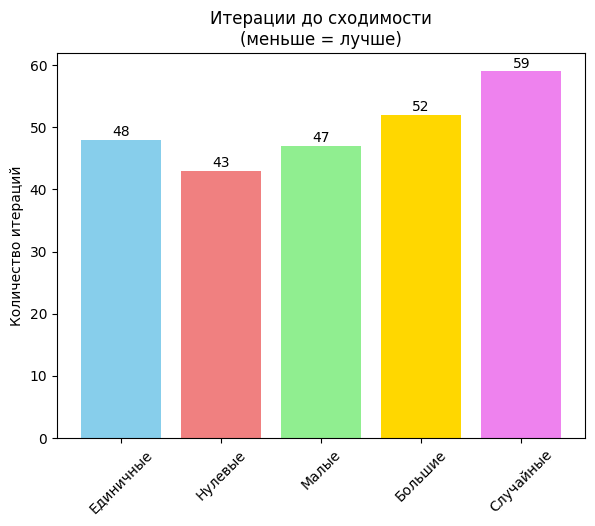


ЛУЧШИЕ РЕЗУЛЬТАТЫ:
Быстрее всего сошелся: Нулевые (43 итераций)
Лучшая точность: Единичные (0.892)

=== ИССЛЕДОВАНИЕ ПАРАМЕТРА β ===
Тест β = 0.6
Сходимость достигнута за 828 итераций
  Итерации: 828, Точность: 0.892
Тест β = 0.7
Сходимость достигнута за 132 итераций
  Итерации: 132, Точность: 0.892
Тест β = 0.8
Сходимость достигнута за 49 итераций
  Итерации: 49, Точность: 0.892
Тест β = 0.9
Сходимость достигнута за 10 итераций
  Итерации: 10, Точность: 0.890
Тест β = 1.0
Сходимость достигнута за 8 итераций
  Итерации: 8, Точность: 0.892


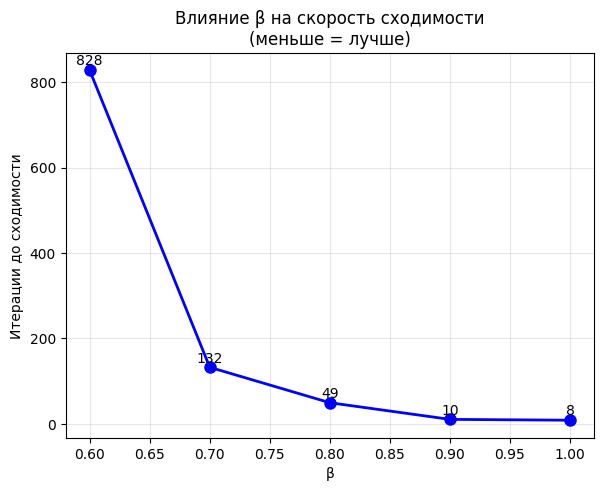


ОПТИМАЛЬНЫЕ ЗНАЧЕНИЯ β:
Для скорости: β = 1.0
Для точности: β = 0.6


In [51]:
# Исследование зависимости скорости сходимости и качества классификации Роббинса-Монро


def test_accuracy(W, X0, X1):
    """Оценка точности классификации на обучающих данных"""
    correct = 0
    total = 0
    
    # Проверяем класс Ω₀
    for x in X0:
        x_aug = np.array([[x[0]], [x[1]], [1]])
        prediction = sgn(W.T @ x_aug)[0,0]
        if prediction == -1:  # Правильно классифицировано как Ω₀
            correct += 1
        total += 1
    
    # Проверяем класс Ω₁  
    for x in X1:
        x_aug = np.array([[x[0]], [x[1]], [1]])
        prediction = sgn(W.T @ x_aug)[0,0]
        if prediction == 1:   # Правильно классифицировано как Ω₁
            correct += 1
        total += 1
    
    return correct / total

def test_initial_conditions(X0, X1):
    """Исследование зависимости от начальных весов"""
    # Разные стратегии инициализации
    initial_weights = [
        np.array([[1.0], [1.0], [1.0]]),      # Единичные веса
        np.array([[0.0], [0.0], [0.0]]),      # Нулевые веса  
        np.array([[0.1], [0.1], [0.1]]),      # Малые веса
        np.array([[10.0], [10.0], [10.0]]),   # Большие веса
        np.random.randn(3, 1)                 # Случайные веса
    ]
    
    labels = ['Единичные', 'Нулевые', 'Малые', 'Большие', 'Случайные']
    results = []
    
    print("=== ИССЛЕДОВАНИЕ НАЧАЛЬНЫХ УСЛОВИЙ ===")
    
    for i, W0 in enumerate(initial_weights):
        print(f"Тест {i+1}: {labels[i]} веса = {W0.flatten()}")
        
        # Запускаем алгоритм
        Warr, iterations = ACP_classifier(X0, X1, W0=W0, max_iterations=1000, beta=0.8)
        
        # Измеряем результаты
        final_W = Warr[-1]
        accuracy = test_accuracy(final_W, X0, X1)
        
        results.append({
            'label': labels[i],
            'initial_weights': W0.flatten(),
            'iterations': iterations,
            'final_weights': final_W.flatten(),
            'accuracy': accuracy
        })
        
        print(f"  Итерации: {iterations}, Точность: {accuracy:.3f}")
        print(f"  Конечные веса: {final_W.flatten()}")  # ← ДОБАВЬТЕ ЭТУ СТРОКУ
    
    # Визуализация результатов
    plt.figure(figsize=(15, 5))
    
    # График 1: Итерации до сходимости
    plt.subplot(1, 2, 1)
    iterations_data = [r['iterations'] for r in results]
    bars = plt.bar(labels, iterations_data, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet'])
    plt.title('Итерации до сходимости\n(меньше = лучше)')
    plt.ylabel('Количество итераций')
    plt.xticks(rotation=45)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, iterations_data):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{value}', ha='center', va='bottom')
    
    # График 2: Точность классификации
    # plt.subplot(1, 2, 2)
    # accuracy_data = [r['accuracy'] for r in results]
    # bars = plt.bar(labels, accuracy_data, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet'])
    # plt.title('Точность классификации\n(больше = лучше)')
    # plt.ylabel('Accuracy')
    # plt.ylim(0, 1.1)
    # plt.xticks(rotation=45)
    
    # # Добавляем значения на столбцы
    # for bar, value in zip(bars, accuracy_data):
    #     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
    #             f'{value:.3f}', ha='center', va='bottom')
    
    
    plt.show()
    
    # Анализ результатов
    best_iterations = min(results, key=lambda x: x['iterations'])
    best_accuracy = max(results, key=lambda x: x['accuracy'])
    
    print(f"\nЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    print(f"Быстрее всего сошелся: {best_iterations['label']} ({best_iterations['iterations']} итераций)")
    print(f"Лучшая точность: {best_accuracy['label']} ({best_accuracy['accuracy']:.3f})")
    
    return results


def test_beta_parameter(X0, X1):
    """Исследование зависимости от параметра β"""
    beta_values = [0.6, 0.7, 0.8, 0.9, 1.0]
    
    results = []
    
    print("\n=== ИССЛЕДОВАНИЕ ПАРАМЕТРА β ===")
    
    for beta in beta_values:
        print(f"Тест β = {beta}")
        
        Warr, iterations = ACP_classifier(X0, X1, max_iterations=1000, beta=beta)
        
        # Анализируем сходимость
        final_W = Warr[-1]
        accuracy = test_accuracy(final_W, X0, X1)
        
        # Анализ стабильности сходимости
        changes = []
        for i in range(1, len(Warr)):
            change = np.linalg.norm(Warr[i] - Warr[i-1])
            changes.append(change)
        
        
        results.append({
            'beta': beta,
            'iterations': iterations,
            'accuracy': accuracy,
            'total_changes': np.sum(changes)  # Общая "активность" обучения
        })
        
        print(f"  Итерации: {iterations}, Точность: {accuracy:.3f}")
    
    # Визуализация результатов
    plt.figure(figsize=(15, 5))
    
    # График 1: Итерации до сходимости
    plt.subplot(1, 2, 1)
    iterations_data = [r['iterations'] for r in results]
    plt.plot(beta_values, iterations_data, 'o-', linewidth=2, markersize=8, color='blue')
    plt.xlabel('β')
    plt.ylabel('Итерации до сходимости')
    plt.title('Влияние β на скорость сходимости\n(меньше = лучше)')
    plt.grid(True, alpha=0.3)
    
    # Добавляем значения на точки
    for beta, iterations in zip(beta_values, iterations_data):
        plt.text(beta, iterations + 5, f'{iterations}', ha='center', va='bottom')
    
    # График 2: Точность классификации
    # plt.subplot(1, 2, 2)
    # accuracy_data = [r['accuracy'] for r in results]
    # plt.plot(beta_values, accuracy_data, 'o-', linewidth=2, markersize=8, color='green')
    # plt.xlabel('β')
    # plt.ylabel('Точность')
    # plt.title('Влияние β на качество\n(больше = лучше)')
    # plt.ylim(0, 1.1)
    # plt.grid(True, alpha=0.3)
    
    # Добавляем значения на точки
    # for beta, accuracy in zip(beta_values, accuracy_data):
    #     plt.text(beta, accuracy + 0.02, f'{accuracy:.3f}', ha='center', va='bottom')
    
    
    plt.show()
    
    # Анализ результатов
    best_beta_iterations = beta_values[np.argmin([r['iterations'] for r in results])]
    best_beta_accuracy = beta_values[np.argmax([r['accuracy'] for r in results])]
    
    print(f"\nОПТИМАЛЬНЫЕ ЗНАЧЕНИЯ β:")
    print(f"Для скорости: β = {best_beta_iterations}")
    print(f"Для точности: β = {best_beta_accuracy}")
    
    return results

# Запускаем исследования
# results_initial = test_initial_conditions(X0_equal, X1_equal)
# results_beta = test_beta_parameter(X0_equal, X1_equal)
results_initial = test_initial_conditions(X0_diff, X1_diff)
results_beta = test_beta_parameter(X0_diff, X1_diff)

# Конечные веса практически идентичны: